## Plots to make

- (pi+, pi0, k-) x dependence of 2009 Hermes data with neural network trained on all hadrons, all dependencies for 2009 Hermes data and plot same on 2020 Hermes Data
- (pi+, pi0, k-) x dependence of 2009 Hermes data with anselmino parametrization trained on all hadrons, all dependencies for 2009 Hermes data and plot same on 2020 Hermes Data

In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import lhapdf
import matplotlib.pyplot as plt

import functions

In [2]:
def dataslicercombined(df, hadrons, dependencies):
    '''
    returns X, y, err
    '''
    df = df.loc[df['hadron'].isin(hadrons), :]
    df = df.loc[df['1D_dependence'].isin(dependencies), :]
    X = np.array(df[['x', 'z', 'phT', 'Q2', 'hadron']])
    for i, had in enumerate(['pi+', 'pi-', 'pi0', 'k+', 'k-']):
        X[X[:, 4] == had, 4] = i
    X = X.astype('float')
    return X, np.array(df['Siv']), np.array(df['tot_err'])

In [3]:
def chisquare(y, yhat, err):
    return np.sum(((y - yhat)/err)**2)

In [337]:
class A0(tf.keras.layers.Layer):
    def __init__(self, kperp2avg=.57, pperp2avg=.12, **kwargs):
        super(A0, self).__init__(name='a0')
        self.m1 = tf.Variable(1., name='m1')
        self.kperp2avg = kperp2avg
        self.pperp2avg = pperp2avg
        self.e = tf.constant(1.)
        
    def get_config(self):
        config = super().get_config().copy()
        
        config.update({
            'kperp2avg': self.kperp2avg,
            'pperp2avg': self.pperp2avg
        })
        
        return config
        
    def call(self, inputs):
        z = inputs[:, 0]
        pht = inputs[:, 1]
        ks2avg = (self.kperp2avg*self.m1**2)/(self.m1**2 + self.kperp2avg) #correct 
        topfirst = (z**2 * self.kperp2avg + self.pperp2avg) * ks2avg**2 #correct
        bottomfirst = (z**2 * ks2avg + self.pperp2avg)**2 * self.kperp2avg #correct
        exptop = pht**2 * z**2 * (ks2avg - self.kperp2avg) #correct
        expbottom = (z**2 * ks2avg + self.pperp2avg) * (z**2 * self.kperp2avg + self.pperp2avg) #correct
        last = tf.sqrt(2*self.e) * z * pht / self.m1 #correct
        
        return (topfirst/bottomfirst) * tf.exp(-exptop/expbottom) * last

In [338]:
class Quotient(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(Quotient, self).__init__()
    
    def call(self, inputs):
        if len(inputs) != 2 or inputs[0].shape[1] != 1:
            raise Exception('must be two tensors of shape (?, 1)')
        return inputs[0]/inputs[1]

In [339]:
def createModel():
    x = tf.keras.Input(shape=(1), name='x')
    z = tf.keras.Input(shape=(1), name='z')
    phT = tf.keras.Input(shape=(1), name='phT')
    uexpr = tf.keras.Input(shape=(1), name='uexpr')
    ubarexpr = tf.keras.Input(shape=(1), name='ubarexpr')
    dexpr = tf.keras.Input(shape=(1), name='dexpr')
    dbarexpr = tf.keras.Input(shape=(1), name='dbarexpr')
    sexpr = tf.keras.Input(shape=(1), name='sexpr')
    sbarexpr = tf.keras.Input(shape=(1), name='sbarexpr')

    hidnnu1 = tf.keras.layers.Dense(32, activation='relu')(x)
    hidnnu2 = tf.keras.layers.Dense(32, activation='relu')(hidnnu1)
    nnuout = tf.keras.layers.Dense(1, name='nnu')(hidnnu2)

    hidnnd1 = tf.keras.layers.Dense(32, activation='relu')(x)
    hidnnd2 = tf.keras.layers.Dense(32, activation='relu')(hidnnd1)
    nndout = tf.keras.layers.Dense(1, name='nnd')(hidnnd2)

    hidnns1 = tf.keras.layers.Dense(32, activation='relu')(x)
    hidnns2 = tf.keras.layers.Dense(32, activation='relu')(hidnns1)
    nnsout = tf.keras.layers.Dense(1, name='nns')(hidnns2)

    hidnnubar1 = tf.keras.layers.Dense(32, activation='relu')(x)
    hidnnubar2 = tf.keras.layers.Dense(32, activation='relu')(hidnnubar1)
    nnubarout = tf.keras.layers.Dense(1, name='nnubar')(hidnnubar2)

    hidnndbar1 = tf.keras.layers.Dense(32, activation='relu')(x)
    hidnndbar2 = tf.keras.layers.Dense(32, activation='relu')(hidnndbar1)
    nndbarout = tf.keras.layers.Dense(1, name='nndbar')(hidnndbar2)

    hidnnsbar1 = tf.keras.layers.Dense(32, activation='relu')(x)
    hidnnsbar2 = tf.keras.layers.Dense(32, activation='relu')(hidnnsbar1)
    nnsbarout = tf.keras.layers.Dense(1, name='nnsbar')(hidnnsbar2)

    nncomb = tf.keras.layers.Concatenate()([nnuout, nnubarout, nndout, nndbarout, nnsout, nnsbarout])

    zpht = tf.keras.layers.Concatenate()([z, phT])
    a0 = A0()(zpht)

    denominator = tf.keras.layers.Add()([uexpr, ubarexpr, dexpr, dbarexpr, sexpr, sbarexpr])

    exprcomb = tf.keras.layers.Concatenate()([uexpr, ubarexpr, dexpr, dbarexpr, sexpr, sbarexpr])

    numerator = tf.keras.layers.Dot(axes=1)([nncomb, exprcomb])

    quo = Quotient()([numerator, denominator])

    siv = tf.keras.layers.Multiply()([a0, quo])

    return tf.keras.Model([x, z, phT, uexpr, ubarexpr, dexpr, dbarexpr, sexpr, sbarexpr],
                         siv)

In [340]:
sivModel = createModel()

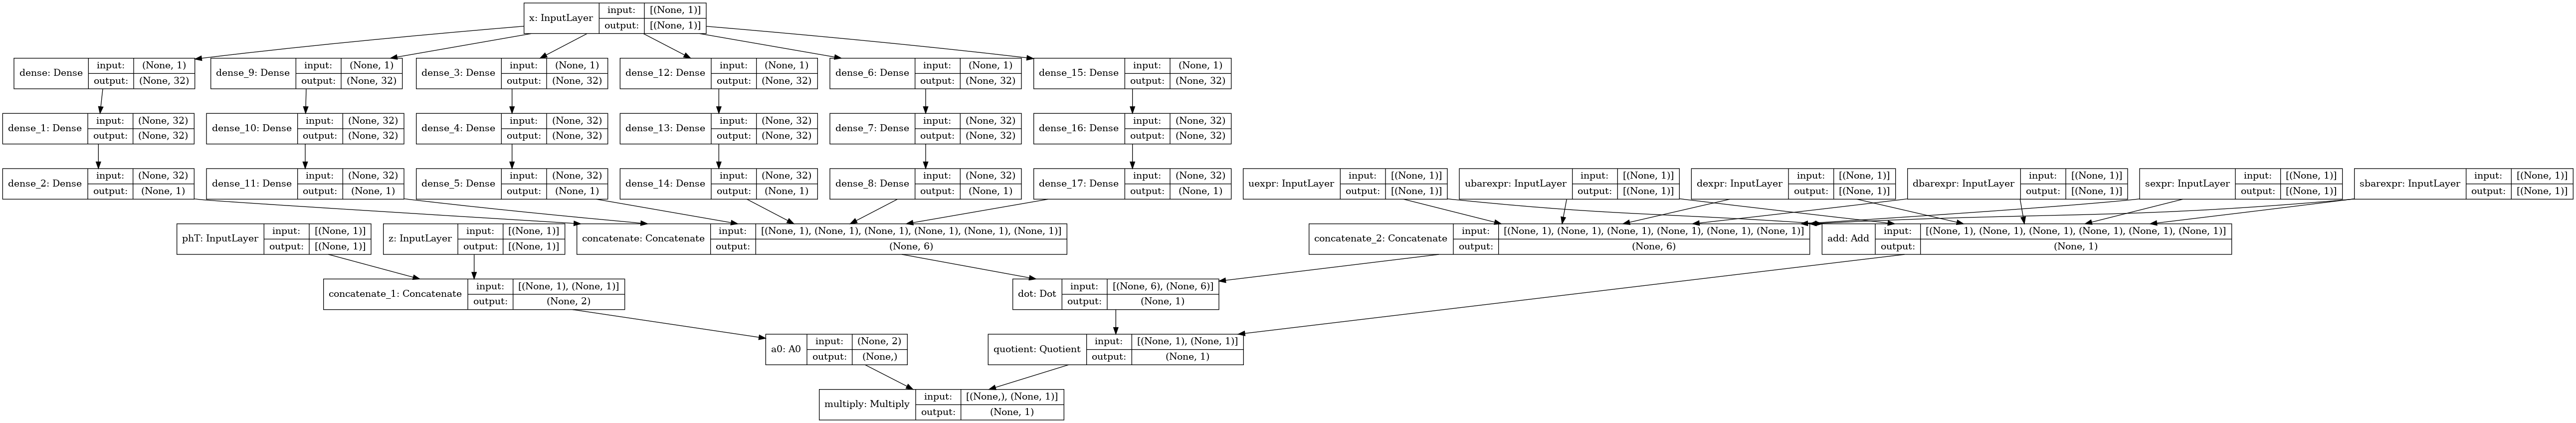

In [8]:
tf.keras.utils.plot_model(sivModel, '/home/nick/model.png', show_shapes=True)

# Tests

In [9]:
testa0 = tf.keras.Model([z, phT], a0)

NameError: name 'z' is not defined

In [31]:
testa0([tf.constant([1., 1.]), tf.constant([2., 2.])])

<tf.Tensor: shape=(2,), dtype=float32, numpy=array([23.175964, 23.175964], dtype=float32)>

In [32]:
i1 = tf.keras.Input(shape=(1))
i2 = tf.keras.Input(shape=(1))
quotest = Quotient()([i1, i2])

In [33]:
testquo = tf.keras.Model([i1, i2], quotest)

In [34]:
testquo([tf.constant([1., 1.]), tf.constant([2., 2.])])

<tf.Tensor: shape=(2, 1), dtype=float32, numpy=
array([[0.5],
       [0.5]], dtype=float32)>

In [35]:
i1 = tf.keras.Input(shape=(3))
i2 = tf.keras.Input(shape=(3))
dottest = tf.keras.layers.dot([i1, i2], 1)

In [36]:
testdot = tf.keras.Model([i1, i2], dottest)

In [39]:
testdot([tf.constant([[1., 1., 1.], [1., 1., 1.]]), tf.constant([[3., 2., 2.], [2., 2., 2.]])])

<tf.Tensor: shape=(2, 1), dtype=float32, numpy=
array([[7.],
       [6.]], dtype=float32)>

In [74]:
num = tf.keras.Model([x, uexpr, ubarexpr, dexpr, dbarexpr, sexpr, sbarexpr], numerator)

In [77]:
num([tf.constant([1.])]*7)

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[-0.7312217]], dtype=float32)>

# More Tests

In [172]:
inputdict = {'x': tf.constant([1., 2.]),
             'z': tf.constant([1., 2.]),
             'phT': tf.constant([1., 2.]),
             'uexpr': tf.constant([1., 2.]),
             'ubarexpr': tf.constant([1., 2.]),
             'dexpr': tf.constant([1., 2.]),
             'dbarexpr': tf.constant([1., 2.]),
             'sexpr': tf.constant([1., 2.]),
             'sbarexpr': tf.constant([1., 2.])}

In [86]:
sivModel = tf.keras.Model([x, z, phT, uexpr, ubarexpr, dexpr, dbarexpr, sexpr, sbarexpr],
                         siv)

In [173]:
sivModel(inputdict)

<tf.Tensor: shape=(2, 1), dtype=float32, numpy=
array([[-0.15126179],
       [-0.51356477]], dtype=float32)>

# Generate Data

In [197]:
herm9 = pd.read_csv('HERMES_p_2009.csv').dropna(axis=0, how='all').dropna(axis=1, how='all')
herm20 = pd.read_csv('HERMES_p_2020.csv').dropna(axis=0, how='all').dropna(axis=1, how='all')
comp9 = pd.read_csv('COMPASS_d_2009.csv').dropna(axis=0, how='all').dropna(axis=1, how='all')
comp15 = pd.read_csv('COMPASS_p_2015.csv').dropna(axis=0, how='all').dropna(axis=1, how='all')

In [198]:
df = herm9

In [199]:
class DataANN(object):
    def __init__(self, pdfset='cteq61',
                 ff_PIp='NNFF10_PIp_nlo', ff_PIm='NNFF10_PIm_nlo', ff_PIsum='NNFF10_PIsum_nlo',
                 ff_KAp='NNFF10_KAp_nlo', ff_KAm='NNFF10_KAm_nlo'):
        '''
        Get data in proper format for neural network
        '''
        self.pdfData = lhapdf.mkPDF(pdfset)
        self.ffDataPIp = lhapdf.mkPDF(ff_PIp, 0)
        self.ffDataPIm = lhapdf.mkPDF(ff_PIm, 0)
        self.ffDataPIsum = lhapdf.mkPDF(ff_PIsum, 0)
        self.ffDataKAp = lhapdf.mkPDF(ff_KAp, 0)
        self.ffDataKAm = lhapdf.mkPDF(ff_KAm, 0)
        # needs to be extended to generalize for kaons
        self.eu = 2/3
        self.eubar = -2/3
        self.ed = -1/3
        self.edbar = 1/3
        self.es = -1/3
        self.esbar = 1/3
        
        self.ffDict = {0: self.ffDataPIp,
                       1: self.ffDataPIm,
                       2: self.ffDataPIsum,
                       3: self.ffDataKAp,
                       4: self.ffDataKAm}
    

    def pdf(self, flavor, x, QQ):
        return np.array([self.pdfData.xfxQ2(flavor, ax, qq) for ax, qq in zip(x, QQ)])
    
    
    def ff(self, func, flavor, z, QQ):
        return np.array([func.xfxQ2(flavor, az, qq) for az, qq in zip(z, QQ)])    
    

    def makeData(self, df, hadrons, dependencies):
        
        data = {'x': [],
             'z': [],
             'phT': [],
             'uexpr': [],
             'ubarexpr': [],
             'dexpr': [],
             'dbarexpr': [],
             'sexpr': [],
             'sbarexpr': []}
        
        y = []
        err = []
        
        df = df.loc[df['hadron'].isin(hadrons), :]
        df = df.loc[df['1D_dependence'].isin(dependencies), :]
        #X = np.array(df[['x', 'z', 'phT', 'Q2', 'hadron']])
        for i, had in enumerate(['pi+', 'pi-', 'pi0', 'k+', 'k-']):
            sliced = df.loc[df['hadron'] == had, :]
            y += list(sliced['Siv'])
            err += list(sliced['tot_err'])
            
            x = sliced['x']
            z = sliced['z']
            QQ = sliced['Q2']
            data['uexpr'] += list(self.eu**2 * self.pdf(2, x, QQ) * self.ff(self.ffDict[i], 2, z, QQ))
            data['ubarexpr'] += list(self.eubar**2 * self.pdf(-2, x, QQ) * self.ff(self.ffDict[i], -2, z, QQ))
            data['dexpr'] += list(self.ed**2 * self.pdf(1, x, QQ) * self.ff(self.ffDict[i], 1, z, QQ))
            data['dbarexpr'] += list(self.edbar**2 * self.pdf(-1, x, QQ) * self.ff(self.ffDict[i], -1, z, QQ))
            data['sexpr'] += list(self.es**2 * self.pdf(3, x, QQ) * self.ff(self.ffDict[i], 3, z, QQ))
            data['sbarexpr'] += list(self.esbar**2 * self.pdf(-3, x, QQ) * self.ff(self.ffDict[i], -3, z, QQ))

            data['x'] += list(x)
            data['z'] += list(z)
            data['phT'] += list(sliced['phT'])
        
        for key in data.keys():
            data[key] = np.array(data[key])
        
        return data, np.array(y), np.array(err)                      
       

In [13]:
datann = DataANN()

In [14]:
X, y, err = datann.makeData(df, ['pi+', 'pi-', 'pi0', 'k+', 'k-'], ['x', 'z', 'phT'])

In [15]:
def trn_tst(X, y, err, split=.2):
    tstidxs = np.random.choice(list(range(len(y))), size=int(len(y)*split), replace=False)
    
    tst_X = {k: v[tstidxs] for k, v in X.items()}
    trn_X = {k: np.delete(v, tstidxs) for k, v in X.items()}
    
    tst_y = y[tstidxs]
    trn_y = np.delete(y, tstidxs)
    
    tst_err = err[tstidxs]
    trn_err = np.delete(err, tstidxs)
    
    return trn_X, tst_X, trn_y, tst_y, trn_err, tst_err

In [16]:
trn_X, tst_X, trn_y, tst_y, trn_err, tst_err = trn_tst(X, y, err)

# Train

In [38]:
sivModel = createModel()

In [39]:
sivModel.compile(
    optimizer = tf.keras.optimizers.Adam(.001),
    loss = tf.keras.losses.MeanSquaredError()
    )

In [40]:
sivModel.fit(trn_X, trn_y, validation_data=(tst_X, tst_y), epochs=100,
             callbacks=[tf.keras.callbacks.EarlyStopping(patience=10)])

Epoch 1/100
3/3 [==============================] - 2s 189ms/step - loss: 0.0028 - val_loss: 0.0021
Epoch 2/100
3/3 [==============================] - 0s 41ms/step - loss: 0.0032 - val_loss: 0.0020
Epoch 3/100
3/3 [==============================] - 0s 45ms/step - loss: 0.0021 - val_loss: 0.0023
Epoch 4/100
3/3 [==============================] - 0s 160ms/step - loss: 0.0036 - val_loss: 0.0020
Epoch 5/100
3/3 [==============================] - 0s 42ms/step - loss: 0.0025 - val_loss: 0.0016
Epoch 6/100
3/3 [==============================] - 0s 40ms/step - loss: 0.0020 - val_loss: 0.0015
Epoch 7/100
3/3 [==============================] - 0s 53ms/step - loss: 0.0024 - val_loss: 0.0014
Epoch 8/100
3/3 [==============================] - 0s 53ms/step - loss: 0.0021 - val_loss: 0.0014
Epoch 9/100
3/3 [==============================] - 0s 41ms/step - loss: 0.0015 - val_loss: 0.0014
Epoch 10/100
3/3 [==============================] - 0s 49ms/step - loss: 0.0015 - val_loss: 0.0013
Epoch 11/100
3/3 

## M1

In [42]:
sivModel.summary()

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
x (InputLayer)                  [(None, 1)]          0                                            
__________________________________________________________________________________________________
dense_108 (Dense)               (None, 32)           64          x[0][0]                          
__________________________________________________________________________________________________
dense_117 (Dense)               (None, 32)           64          x[0][0]                          
__________________________________________________________________________________________________
dense_111 (Dense)               (None, 32)           64          x[0][0]                          
____________________________________________________________________________________________

In [43]:
sivModel.get_layer('a0_6').get_weights()

[1.0028043]

# Validation $\chi^2/dof$

In [44]:
def calc_yhat(model, X):
    return np.array([x[0] for x in model.predict(X)])

In [45]:
yhat = calc_yhat(sivModel, tst_X)

In [46]:
chisquare(tst_y, yhat, tst_err)/len(yhat)

4.1037516676713395

# Plot

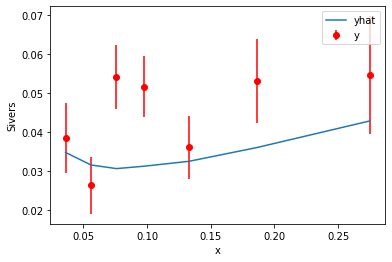

In [163]:
Xplt, yplt, errplt = datann.makeData(df, ['pi+'], ['x'])

yhatplt = calc_yhat(sivModel, Xplt)

plt.plot(Xplt['x'], yhatplt, label='yhat')
plt.errorbar(Xplt['x'], yplt, yerr=errplt, fmt='ro', label='y')
plt.legend()
plt.ylabel('Sivers')
plt.xlabel('x')
plt.show()

# For all combined data

## Data

In [14]:
df = pd.concat([herm9, herm20, comp9, comp15])

In [15]:
datann = DataANN()

In [16]:
X, y, err = datann.makeData(df, ['pi+', 'pi-', 'pi0', 'k+', 'k-'], ['x', 'z', 'phT'])

In [17]:
trn_X, tst_X, trn_y, tst_y, trn_err, tst_err = trn_tst(X, y, err)

## Train

In [38]:
sivModel = createModel()

In [39]:
sivModel.compile(
    optimizer = tf.keras.optimizers.Adam(.01),
    loss = tf.keras.losses.MeanSquaredError()
    )

In [40]:
sivModel.fit(trn_X, trn_y, validation_data=(tst_X, tst_y), sample_weight=1/trn_err, epochs=200)

Epoch 1/200
12/12 [==============================] - 2s 43ms/step - loss: 0.5574 - val_loss: 0.0352
Epoch 2/200
12/12 [==============================] - 0s 13ms/step - loss: 13.5381 - val_loss: 0.0036
Epoch 3/200
12/12 [==============================] - 0s 10ms/step - loss: 2.0466 - val_loss: 0.0104
Epoch 4/200
12/12 [==============================] - 0s 9ms/step - loss: 0.3772 - val_loss: 0.0044
Epoch 5/200
12/12 [==============================] - 0s 12ms/step - loss: 0.7675 - val_loss: 0.0048
Epoch 6/200
12/12 [==============================] - 0s 8ms/step - loss: 0.1771 - val_loss: 0.0033
Epoch 7/200
12/12 [==============================] - 0s 12ms/step - loss: 0.6751 - val_loss: 0.0030
Epoch 8/200
12/12 [==============================] - 0s 12ms/step - loss: 0.1344 - val_loss: 0.0031
Epoch 9/200
12/12 [==============================] - 0s 14ms/step - loss: 0.1026 - val_loss: 0.0029
Epoch 10/200
12/12 [==============================] - 0s 8ms/step - loss: 0.1013 - val_loss: 0.0030
E

12/12 [==============================] - 0s 19ms/step - loss: 0.0643 - val_loss: 0.0028
Epoch 163/200
12/12 [==============================] - 0s 8ms/step - loss: 0.0625 - val_loss: 0.0028
Epoch 164/200
12/12 [==============================] - 0s 18ms/step - loss: 0.0648 - val_loss: 0.0028
Epoch 165/200
12/12 [==============================] - 0s 9ms/step - loss: 0.0599 - val_loss: 0.0028
Epoch 166/200
12/12 [==============================] - 0s 10ms/step - loss: 0.0622 - val_loss: 0.0028
Epoch 167/200
12/12 [==============================] - 0s 20ms/step - loss: 0.0637 - val_loss: 0.0028
Epoch 168/200
12/12 [==============================] - 0s 17ms/step - loss: 0.0677 - val_loss: 0.0028
Epoch 169/200
12/12 [==============================] - 0s 16ms/step - loss: 0.0641 - val_loss: 0.0028
Epoch 170/200
12/12 [==============================] - 0s 13ms/step - loss: 0.0575 - val_loss: 0.0028
Epoch 171/200
12/12 [==============================] - 0s 14ms/step - loss: 0.0696 - val_loss: 0.0

## Validation $\chi^2/dof$

In [41]:
yhat = calc_yhat(sivModel, tst_X)

In [42]:
chisquare(tst_y, yhat, tst_err)/len(yhat)

3.8103448732696727

## Plot

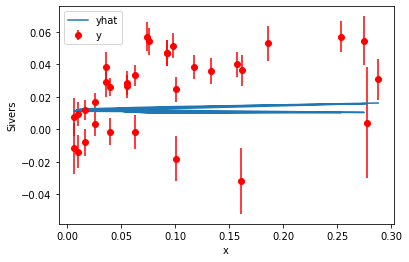

In [44]:
Xplt, yplt, errplt = datann.makeData(df, ['pi+'], ['x'])

yhatplt = calc_yhat(sivModel, Xplt)

plt.plot(Xplt['x'], yhatplt, label='yhat')
plt.errorbar(Xplt['x'], yplt, yerr=errplt, fmt='ro', label='y')
plt.legend()
plt.ylabel('Sivers')
plt.xlabel('x')
plt.show()

# Hermes 2009

In [26]:
df = pd.concat([herm9])

In [27]:
datann = DataANN()

In [28]:
X, y, err = datann.makeData(df, ['pi+', 'pi-', 'pi0', 'k+', 'k-'], ['x', 'z', 'phT'])

In [29]:
trn_X, tst_X, trn_y, tst_y, trn_err, tst_err = trn_tst(X, y, err)

## Train

In [14]:
sivModel = createModel()

sivModel.compile(
    optimizer = tf.keras.optimizers.Adam(.01),
    loss = tf.keras.losses.MeanSquaredError()
    )

In [15]:
sivModel.fit(trn_X, trn_y, validation_data=(tst_X, tst_y), sample_weight=1/trn_err, epochs=200)

Epoch 1/200
3/3 [==============================] - 2s 434ms/step - loss: 0.1207 - val_loss: 0.0015
Epoch 2/200
3/3 [==============================] - 0s 48ms/step - loss: 0.1728 - val_loss: 0.0016
Epoch 3/200
3/3 [==============================] - 0s 55ms/step - loss: 0.2989 - val_loss: 0.0016
Epoch 4/200
3/3 [==============================] - 0s 50ms/step - loss: 0.0962 - val_loss: 0.0013
Epoch 5/200
3/3 [==============================] - 0s 51ms/step - loss: 0.0797 - val_loss: 0.0012
Epoch 6/200
3/3 [==============================] - 0s 51ms/step - loss: 0.0809 - val_loss: 0.0012
Epoch 7/200
3/3 [==============================] - 0s 41ms/step - loss: 0.0478 - val_loss: 0.0012
Epoch 8/200
3/3 [==============================] - 0s 58ms/step - loss: 0.0489 - val_loss: 0.0012
Epoch 9/200
3/3 [==============================] - 0s 123ms/step - loss: 0.0490 - val_loss: 0.0011
Epoch 10/200
3/3 [==============================] - 0s 113ms/step - loss: 0.0454 - val_loss: 0.0012
Epoch 11/200
3/3

Epoch 165/200
3/3 [==============================] - 0s 52ms/step - loss: 0.0270 - val_loss: 0.0013
Epoch 166/200
3/3 [==============================] - 0s 120ms/step - loss: 0.0232 - val_loss: 0.0013
Epoch 167/200
3/3 [==============================] - 0s 94ms/step - loss: 0.0240 - val_loss: 0.0013
Epoch 168/200
3/3 [==============================] - 0s 58ms/step - loss: 0.0283 - val_loss: 0.0013
Epoch 169/200
3/3 [==============================] - 0s 129ms/step - loss: 0.0251 - val_loss: 0.0013
Epoch 170/200
3/3 [==============================] - 0s 113ms/step - loss: 0.0299 - val_loss: 0.0013
Epoch 171/200
3/3 [==============================] - 0s 59ms/step - loss: 0.0268 - val_loss: 0.0013
Epoch 172/200
3/3 [==============================] - 0s 114ms/step - loss: 0.0242 - val_loss: 0.0013
Epoch 173/200
3/3 [==============================] - 0s 64ms/step - loss: 0.0283 - val_loss: 0.0013
Epoch 174/200
3/3 [==============================] - 0s 97ms/step - loss: 0.0255 - val_loss: 0.0

In [16]:
sivModel.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
x (InputLayer)                  [(None, 1)]          0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 32)           64          x[0][0]                          
__________________________________________________________________________________________________
dense_9 (Dense)                 (None, 32)           64          x[0][0]                          
__________________________________________________________________________________________________
dense_3 (Dense)                 (None, 32)           64          x[0][0]                          
______________________________________________________________________________________________

In [17]:
sivModel.get_layer('a0').get_weights()

[2.0126815]

## Validation $\chi^2/dof$

In [127]:
def calc_yhat(model, X):
    preds = model.predict(X)
    return np.array([x[0] for x in preds])

In [128]:
yhat = calc_yhat(sivModel, tst_X)

chisquare(tst_y, yhat, tst_err)/len(yhat)

2.0375632392591903

## Plot

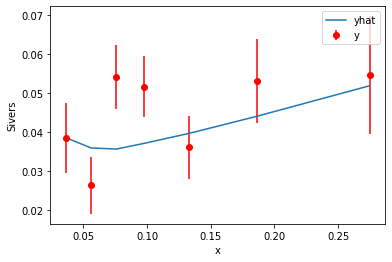

In [33]:
Xplt, yplt, errplt = datann.makeData(df, ['pi+'], ['x'])

yhatplt = calc_yhat(sivModel, Xplt)

plt.plot(Xplt['x'], yhatplt,  label='yhat')
plt.errorbar(Xplt['x'], yplt, yerr=errplt, fmt='ro', label='y')
plt.legend()
plt.ylabel('Sivers')
plt.xlabel('x')
plt.show()

# Predict 2020

In [22]:
df = pd.concat([herm20])

datann = DataANN()

X, y, err = datann.makeData(df, ['pi+', 'pi-', 'pi0', 'k+', 'k-'], ['x', 'z', 'phT'])

In [23]:
yhat = calc_yhat(sivModel, X)

## Validation $\chi^2/dof$

In [24]:
chisquare(y, yhat, err)/len(yhat)

3.5729839781990247

# Plot

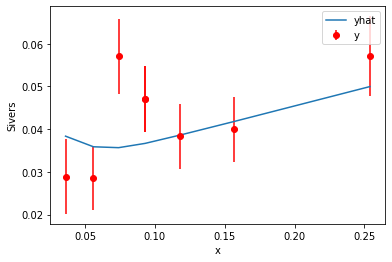

In [25]:
Xplt, yplt, errplt = datann.makeData(df, ['pi+'], ['x'])

yhatplt = calc_yhat(sivModel, Xplt)

plt.plot(Xplt['x'], yhatplt,  label='yhat')
plt.errorbar(Xplt['x'], yplt, yerr=errplt, fmt='ro', label='y')
plt.legend()
plt.ylabel('Sivers')
plt.xlabel('x')
plt.show()

# Error Estimation

In [394]:
sivModel = createModel()

In [395]:
sivModel(X)

<tf.Tensor: shape=(8, 1), dtype=float32, numpy=
array([[ 0.00587196],
       [ 0.01763657],
       [ 0.03172313],
       [ 0.20117351],
       [ 0.20117351],
       [ 1.348309  ],
       [-0.07025343],
       [-0.01765836]], dtype=float32)>

In [396]:
sivModel.save('Models/test.h5', save_format='h5')

In [71]:
A0

__main__.A0

In [73]:
Quotient

__main__.Quotient

In [397]:
t = tf.keras.models.load_model('Models/test.h5', custom_objects={'A0': A0, 'Quotient': Quotient})

In [88]:
from tqdm import tqdm

In [399]:
def trainReplicas(X, y, err, numReplicas):
    for i in range(numReplicas):
        yrep = np.random.normal(y, err)
        
        model = createModel()
        
        sivModel.compile(
            optimizer = tf.keras.optimizers.Adam(.01),
            loss = tf.keras.losses.MeanSquaredError()
            )
        
        sivModel.fit(X, yrep, epochs=50, verbose=2)
        
        sivModel.save('Models/rep' + str(i) + '.h5', save_format='h5')

In [400]:
df = pd.concat([herm9])
X, y, err = datann.makeData(df, ['pi+', 'pi-', 'pi0', 'k+', 'k-'], ['x', 'z', 'phT'])

In [401]:
trainReplicas(X, y, err, 10)

Epoch 1/50
4/4 - 1s - loss: 0.0159
Epoch 2/50
4/4 - 0s - loss: 0.0115
Epoch 3/50
4/4 - 0s - loss: 0.0036
Epoch 4/50
4/4 - 0s - loss: 0.0042
Epoch 5/50
4/4 - 0s - loss: 0.0027
Epoch 6/50
4/4 - 0s - loss: 0.0029
Epoch 7/50
4/4 - 0s - loss: 0.0026
Epoch 8/50
4/4 - 0s - loss: 0.0025
Epoch 9/50
4/4 - 0s - loss: 0.0023
Epoch 10/50
4/4 - 0s - loss: 0.0025
Epoch 11/50
4/4 - 0s - loss: 0.0021
Epoch 12/50
4/4 - 0s - loss: 0.0021
Epoch 13/50
4/4 - 0s - loss: 0.0019
Epoch 14/50
4/4 - 0s - loss: 0.0022
Epoch 15/50
4/4 - 0s - loss: 0.0022
Epoch 16/50
4/4 - 0s - loss: 0.0019
Epoch 17/50
4/4 - 0s - loss: 0.0020
Epoch 18/50
4/4 - 0s - loss: 0.0018
Epoch 19/50
4/4 - 0s - loss: 0.0018
Epoch 20/50
4/4 - 0s - loss: 0.0019
Epoch 21/50
4/4 - 0s - loss: 0.0018
Epoch 22/50
4/4 - 0s - loss: 0.0019
Epoch 23/50
4/4 - 0s - loss: 0.0020
Epoch 24/50
4/4 - 0s - loss: 0.0026
Epoch 25/50
4/4 - 0s - loss: 0.0031
Epoch 26/50
4/4 - 0s - loss: 0.0027
Epoch 27/50
4/4 - 0s - loss: 0.0025
Epoch 28/50
4/4 - 0s - loss: 0.0029
E

Epoch 30/50
4/4 - 0s - loss: 0.0013
Epoch 31/50
4/4 - 0s - loss: 0.0013
Epoch 32/50
4/4 - 0s - loss: 0.0013
Epoch 33/50
4/4 - 0s - loss: 0.0013
Epoch 34/50
4/4 - 0s - loss: 0.0013
Epoch 35/50
4/4 - 0s - loss: 0.0013
Epoch 36/50
4/4 - 0s - loss: 0.0013
Epoch 37/50
4/4 - 0s - loss: 0.0013
Epoch 38/50
4/4 - 0s - loss: 0.0013
Epoch 39/50
4/4 - 0s - loss: 0.0013
Epoch 40/50
4/4 - 0s - loss: 0.0013
Epoch 41/50
4/4 - 0s - loss: 0.0013
Epoch 42/50
4/4 - 0s - loss: 0.0013
Epoch 43/50
4/4 - 0s - loss: 0.0013
Epoch 44/50
4/4 - 0s - loss: 0.0013
Epoch 45/50
4/4 - 0s - loss: 0.0013
Epoch 46/50
4/4 - 0s - loss: 0.0013
Epoch 47/50
4/4 - 0s - loss: 0.0013
Epoch 48/50
4/4 - 0s - loss: 0.0013
Epoch 49/50
4/4 - 0s - loss: 0.0013
Epoch 50/50
4/4 - 0s - loss: 0.0013
Epoch 1/50
4/4 - 2s - loss: 0.0021
Epoch 2/50
4/4 - 0s - loss: 0.0018
Epoch 3/50
4/4 - 0s - loss: 0.0019
Epoch 4/50
4/4 - 0s - loss: 0.0015
Epoch 5/50
4/4 - 0s - loss: 0.0021
Epoch 6/50
4/4 - 0s - loss: 0.0014
Epoch 7/50
4/4 - 0s - loss: 0.0016

Epoch 9/50
4/4 - 0s - loss: 0.0015
Epoch 10/50
4/4 - 0s - loss: 0.0015
Epoch 11/50
4/4 - 0s - loss: 0.0015
Epoch 12/50
4/4 - 0s - loss: 0.0014
Epoch 13/50
4/4 - 0s - loss: 0.0014
Epoch 14/50
4/4 - 0s - loss: 0.0014
Epoch 15/50
4/4 - 0s - loss: 0.0014
Epoch 16/50
4/4 - 0s - loss: 0.0014
Epoch 17/50
4/4 - 0s - loss: 0.0014
Epoch 18/50
4/4 - 0s - loss: 0.0014
Epoch 19/50
4/4 - 0s - loss: 0.0014
Epoch 20/50
4/4 - 0s - loss: 0.0016
Epoch 21/50
4/4 - 0s - loss: 0.0014
Epoch 22/50
4/4 - 0s - loss: 0.0014
Epoch 23/50
4/4 - 0s - loss: 0.0014
Epoch 24/50
4/4 - 0s - loss: 0.0014
Epoch 25/50
4/4 - 0s - loss: 0.0014
Epoch 26/50
4/4 - 0s - loss: 0.0014
Epoch 27/50
4/4 - 0s - loss: 0.0014
Epoch 28/50
4/4 - 0s - loss: 0.0014
Epoch 29/50
4/4 - 0s - loss: 0.0014
Epoch 30/50
4/4 - 0s - loss: 0.0014
Epoch 31/50
4/4 - 0s - loss: 0.0014
Epoch 32/50
4/4 - 0s - loss: 0.0014
Epoch 33/50
4/4 - 0s - loss: 0.0014
Epoch 34/50
4/4 - 0s - loss: 0.0014
Epoch 35/50
4/4 - 0s - loss: 0.0014
Epoch 36/50
4/4 - 0s - loss: 

In [129]:
def evaluateReplicas(tst_X, tst_y, tst_err, numReplicas):
    results = []
    for i in range(numReplicas):
        mod = tf.keras.models.load_model('Models/rep' + str(i) + '.h5', 
                                         custom_objects={'A0': A0, 'Quotient': Quotient})
        results.append(list(calc_yhat(mod, tst_X)))
    return np.array(results)

In [130]:
results = evaluateReplicas(X, y, err, 10)

In [131]:
results.mean(axis=0)

array([ 0.02235046,  0.03035551,  0.03760971,  0.0444922 ,  0.04946075,
        0.05123565,  0.05040111,  0.03829439,  0.03443765,  0.03303076,
        0.03324153,  0.03390182,  0.03687324,  0.04972754,  0.00963769,
        0.01881231,  0.02602083,  0.03312055,  0.04431242,  0.06551264,
        0.11002989,  0.01413377,  0.0152113 ,  0.01264528,  0.0050286 ,
       -0.00399545, -0.00996983, -0.01233296,  0.01673105,  0.013241  ,
        0.01179966,  0.01119346,  0.01148146,  0.01400495,  0.02594689,
        0.00398866,  0.00737656,  0.00993403,  0.01271243,  0.01689881,
        0.02163405,  0.01917627,  0.02062746,  0.02626355,  0.03075186,
        0.03375929,  0.03494479,  0.03601346,  0.03591052,  0.03270379,
        0.02916353,  0.02847156,  0.02817603,  0.028721  ,  0.03209467,
        0.04742257,  0.00802225,  0.01482954,  0.02004489,  0.02529709,
        0.03373842,  0.04815888,  0.07638187,  0.0393762 ,  0.04694817,
        0.05237201,  0.05402082,  0.05162167,  0.04592303,  0.03

In [110]:
len(y)

105

In [111]:
chisquare(y, results.mean(axis=0), err)/len(y)

1.635111723072009

In [293]:
def plotBands(df, hadron, dependence, numReplicas, title, ylab, numSigma=2):
    datann = DataANN()
    X, y, err = datann.makeData(df, [hadron], [dependence])

    results = evaluateReplicas(X, y, err, numReplicas)
    #return results, X
    #return X, y, err, results
    #plt.errorbar(X[dependence], results.mean(axis=0), yerr=results.std(axis=0),
    #             fmt='r', label='yhat')
    
    
    yhat = results.mean(axis=0)
    yerr = results.std(axis=0)
    #return X[dependence], yhat-2*yerr, yhat+2*yerr, yhat
    plt.fill_between(X[dependence], yhat-numSigma*yerr, yhat+numSigma*yerr,
                     facecolor='r', alpha=0.3, label='Fit')
    print(X[dependence], '\n', y)
    plt.errorbar(X[dependence], y, yerr=numSigma*err,
             fmt='bo', label='Data')
    
    plt.legend()
    plt.title(title)
    plt.xlabel(dependence)
    plt.ylabel(ylab)
    plt.savefig(title + '.pdf', format='pdf')

[0.036 0.056 0.076 0.098 0.133 0.186 0.275] 
 [0.0385 0.0264 0.0542 0.0516 0.0361 0.0531 0.0546]


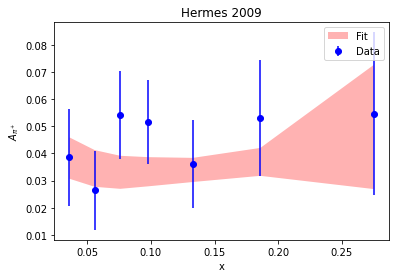

In [298]:
results = plotBands(herm9, 'pi+', 'x', 10, 'Hermes 2009', '$A_{\pi^+}$')

In [152]:
len(results.mean(axis=0))

7

In [166]:
X, y, err = datann.makeData(herm20, ['pi+', 'pi-', 'pi0', 'k+', 'k-'], ['x', 'z', 'phT'])

In [167]:
results = evaluateReplicas(X, y, err, 10)

In [168]:
chisquare(y, results.mean(axis=0), err)/len(y)

2.0236220336275546

# Chi-squares

In [288]:
X, y, err = datann.makeData(herm20, ['k-'], ['phT'])

In [289]:
results = evaluateReplicas(X, y, err, 10)

In [290]:
chisquare(y, results.mean(axis=0), err)/len(y)

2.929985691017823

# Sivers Distribution

In [358]:
def nnq(model, x, hadronstr):
    if not hadronstr in ['nnu', 'nnd', 'nns', 'nnubar', 'nndbar', 'nnsbar']:
        raise Exception('hadronstr must be one of nnu, nnd, nns, nnubar, nndbar, nnsbar')
    lilmod = tf.keras.backend.function(model.get_layer('x').input,
                                       model.get_layer(hadronstr).output)
    return lilmod(x)

In [341]:
sivModel = createModel()

In [349]:
sivModel.get_layer('a0').m1.numpy()

1.0

In [359]:
def h(model, kperp):
    m1 = model.get_layer('a0').m1.numpy()
    e = model.get_layer('a0').e.numpy()
    return np.sqrt(2*e) * (kperp/m1) * np.exp(-kperp**2/m1**2)

In [360]:
import NewFunctions

In [361]:
def fqp(x, QQ, kperp2avg, kperp, flavor):
    '''
    x and QQ must be iterables of some kind
    '''
    had = NewFunctions.Hadron()
    fq = had.pdf(flavor, x, QQ)
    return fq*(1/(np.pi*kperp2avg))*np.exp(-kperp**2/kperp2avg)

In [367]:
nnq(sivModel, np.array([1.]), 'nnu')

array([[-0.01141872]], dtype=float32)

In [389]:
def xsivdist(model, x, QQ, kperp2avg, flavor, kperp):
    refDict = {-3: 'nnsbar',
               -2: 'nnubar',
               -1: 'nndbar',
               1: 'nnd',
               2: 'nnu',
               3: 'nns'}
    nnqval = nnq(model, np.array([x]), refDict[flavor])
    hval = h(model, kperp)
    fqpval = fqp([x], [QQ], kperp2avg, kperp, flavor)
    
    return ((2*nnqval*hval*fqpval)[0, :])*x

In [386]:
dist = xsivdist(sivModel, .1, 2.4, .52, -2, np.array(list(range(150)))/100)

In [402]:
def xsivdistFromReplicas(numReplicas, x, QQ, kperp2avg, flavor, kperp):
    results = []
    for i in range(numReplicas):
        t = tf.keras.models.load_model('Models/rep' + str(i) + '.h5', 
                                         custom_objects={'A0': A0, 'Quotient': Quotient})
        results.append(list(xsivdist(t, x, QQ, kperp2avg, flavor, kperp)))
    return np.array(results)

In [403]:
results = xsivdistFromReplicas(10, .1, 2.4, .57, 2, np.array(list(range(150)))/100)

In [422]:
def plotSivDistBands(numReplicas, x, QQ, kperp2avg, flavor, kperp, numSigma=2):
    #datann = DataANN()
    #X, y, err = datann.makeData(df, [hadron], [dependence])

    results = xsivdistFromReplicas(numReplicas, x, QQ, kperp2avg, 2, kperp)
    yhat = results.mean(axis=0)
    yerr = results.std(axis=0)

    plt.fill_between(kperp, yhat-numSigma*yerr, yhat+numSigma*yerr,
                     facecolor='b', alpha=0.3, label='$u$')
    plt.plot(kperp, yhat, 'b')
    
    results = xsivdistFromReplicas(numReplicas, x, QQ, kperp2avg, 1, kperp)
    yhat = results.mean(axis=0)
    yerr = results.std(axis=0)
    
    plt.fill_between(kperp, yhat-numSigma*yerr, yhat+numSigma*yerr,
                     facecolor='r', alpha=0.3, label='$d$')
    plt.plot(kperp, yhat, 'r')
    
    results = xsivdistFromReplicas(numReplicas, x, QQ, kperp2avg, 3, kperp)
    yhat = results.mean(axis=0)
    yerr = results.std(axis=0)
    
    plt.fill_between(kperp, yhat-numSigma*yerr, yhat+numSigma*yerr,
                     facecolor='g', alpha=0.3, label='$s$')
    plt.plot(kperp, yhat, 'g')
    
    plt.legend()
    plt.title('Hermes 2009')
    plt.xlabel('$k_{\perp}$')
    plt.ylabel('$x\Delta^Nf(x, k_{\perp})$')
    plt.savefig('2009HermesUDS.pdf', format='pdf', bbox_inches='tight')

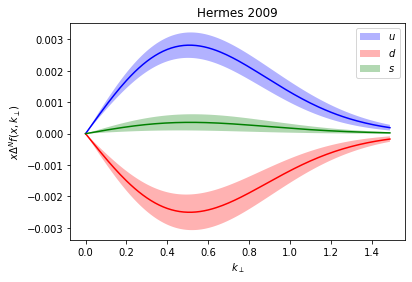

In [423]:
plotSivDistBands(10, .1, 2.4, .57, -2, np.array(list(range(150)))/100)

In [424]:
def plotSivDistBandsSea(numReplicas, x, QQ, kperp2avg, flavor, kperp, numSigma=2):
    #datann = DataANN()
    #X, y, err = datann.makeData(df, [hadron], [dependence])

    results = xsivdistFromReplicas(numReplicas, x, QQ, kperp2avg, -2, kperp)
    yhat = results.mean(axis=0)
    yerr = results.std(axis=0)

    plt.fill_between(kperp, yhat-numSigma*yerr, yhat+numSigma*yerr,
                     facecolor='b', alpha=0.3, label='$u_{sea}$')
    plt.plot(kperp, yhat, 'b')
    
    results = xsivdistFromReplicas(numReplicas, x, QQ, kperp2avg, -1, kperp)
    yhat = results.mean(axis=0)
    yerr = results.std(axis=0)
    
    plt.fill_between(kperp, yhat-numSigma*yerr, yhat+numSigma*yerr,
                     facecolor='r', alpha=0.3, label='$d_{sea}$')
    plt.plot(kperp, yhat, 'r')
    
    results = xsivdistFromReplicas(numReplicas, x, QQ, kperp2avg, -3, kperp)
    yhat = results.mean(axis=0)
    yerr = results.std(axis=0)
    
    plt.fill_between(kperp, yhat-numSigma*yerr, yhat+numSigma*yerr,
                     facecolor='g', alpha=0.3, label='$s_{sea}$')
    plt.plot(kperp, yhat, 'g')
    
    plt.legend()
    plt.title('Hermes 2009')
    plt.xlabel('$k_{\perp}$')
    plt.ylabel('$x\Delta^Nf(x, k_{\perp})$')
    plt.savefig('2009HermesUDSsea.pdf', format='pdf', bbox_inches='tight')

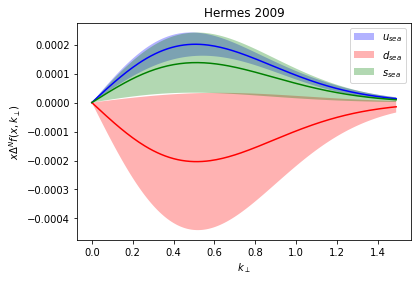

In [426]:
plotSivDistBandsSea(10, .1, 2.4, .57, -2, np.array(list(range(150)))/100)

In [324]:
nn(sivModel, X['x'], 'nns')

array([[-0.01919166],
       [-0.01863268],
       [-0.01788737],
       [-0.01658309],
       [-0.01658309],
       [-0.01565145],
       [-0.01490614],
       [-0.01360186]], dtype=float32)